In [1]:
"""
Manuscript figures
"""

import os, sys
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable, get_cmap
import matplotlib.patches as mpatches

from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
from sklearn.preprocessing import MinMaxScaler
from mapclassify import Quantiles

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Function to format colorbar labels with 'k' notation
def format_ticks(value, _):
    return f'{int(value / 1000)}k'
    
proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
icsdir = os.path.join(maindir, 'ics209-plus-fired/data/')

print("Ready !")

Ready !


In [2]:
# load fire perimeter data
fp = os.path.join(projdir,'data/spatial/mod/srm_fire_census_2017_to_2023_ics_perims.gpkg')
fires = gpd.read_file(fp)
fires.columns

Index(['Fire_ID', 'Fire_Name', 'Final_Acres', 'Source', 'Aspen_Pct',
       'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'ICS_ACRES', 'CAUSE',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')

In [3]:
# load the frp grid
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry'],
      dtype='object')

In [4]:
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','NA_L3CODE','geometry']].rename(columns={'NA_L3NAME': 'na_l3name', 'NA_L3CODE': 'na_l3code'})
ecol3.columns

Index(['na_l3name', 'na_l3code', 'geometry'], dtype='object')

## Figure 1A. Map of the Southern Rockies

Figure 1. Study region and wildfire events. (A) Map of the SRM showing the locations of wildfire events with >1% pre-fire aspen cover. Point size represents the burned area (ha), color scale represents the percentage of aspen forest cover; (B) annual burned area (ha); (C) distribution of fire size (or other statistics ??).

In [5]:
print(fires['Aspen_Pct'].astype(float).describe())

count    115.000000
mean      14.586210
std       18.894022
min        0.000000
25%        0.445986
50%        6.958022
75%       21.287724
max       88.679245
Name: Aspen_Pct, dtype: float64


count       100.000000
mean       6662.475118
std       19547.772302
min          40.468600
25%         290.564548
50%         666.113156
75%        3042.328176
max      138295.370210
Name: FINAL_HA, dtype: float64


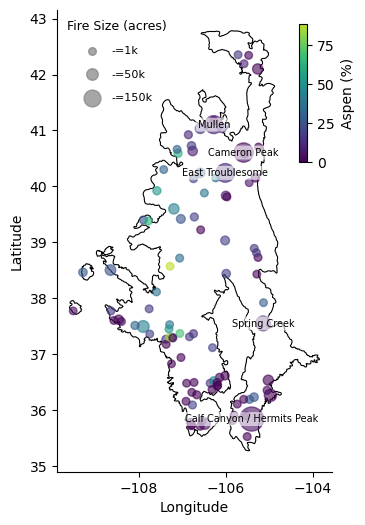

In [67]:
# Generate centroids
fires = fires[fires['Fire_ID'].isin(grid['Fire_ID'].unique())]
fires['Final_Acres'] = fires['Final_Acres'].astype(float)
fires['ICS_ACRES'] = pd.to_numeric(fires['ICS_ACRES'], errors='coerce')
fires['FINAL_KM2'] = fires['ICS_ACRES'] * 0.00404686
fires['FINAL_HA'] = fires['ICS_ACRES']* 0.404686
fires['LOG_FINAL_HA'] = np.log(fires['FINAL_HA']) 
fires['Aspen_Pct'] = fires['Aspen_Pct'].astype(float)
print(fires['FINAL_HA'].describe())

# Get the centroid of fires
centroid = fires.copy()
centroid['geometry'] = centroid.geometry.centroid
# scale fire size attribute for display
scaler = MinMaxScaler(feature_range=(10, 100))  # Marker sizes between 10 and 200
centroid['fire_size'] = scaler.fit_transform(centroid[['Final_Acres']]) * 3
# subset to SRM
srm = ecol3[ecol3['na_l3name'] == 'Southern Rockies']
# ensure the same projection
centroid = centroid.to_crs(4326)
srm = srm.to_crs(4326)

# isolate large fires for labeling
label_dict = {
    '16': 'Calf Canyon / Hermits Peak',
    '89': 'East Troublesome',
    '48': 'Cameron Peak',
    '90': 'Mullen',
    '110': 'Spring Creek'
}
large_fires = centroid[centroid['Fire_ID'].isin(label_dict.keys())]

# function to truncate colormap
def truncate_colormap(cmap_name, min_val=0.2, max_val=0.8, n_colors=256):
    cmap = get_cmap(cmap_name)
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f"{cmap_name}_trunc", cmap(np.linspace(min_val, max_val, n_colors))
    )
    return new_cmap

# Create a softer version of inferno_r
soft_viridis_r = truncate_colormap("viridis", min_val=0., max_val=0.9)

# plot it
fig, ax = plt.subplots(figsize=(6, 6))

srm.plot(ax=ax, edgecolor='black', linewidth=0.8, color='none')
centroid.plot(
    ax=ax, 
    markersize=centroid['fire_size'],  # Use normalized marker size
    column='Aspen_Pct', cmap=soft_viridis_r, 
    legend=False, alpha=0.6)

# Labels and saving
plt.xlabel('Longitude', size=10)
plt.ylabel('Latitude', size=10)

# Remove top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for _, row in large_fires.iterrows():
    x, y = row.geometry.x, row.geometry.y
    fire_id = str(row['Fire_ID'])  # Ensure Fire_ID is a string to match dictionary keys
    label = label_dict.get(fire_id, '')

    ax.text(
        x, y,
        label,
        fontsize=7,
        color='black',
        weight='normal',
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2', edgecolor='none')
    )
    
# Add colorbar
# normalize and scale the values
norm = mcolors.Normalize(vmin=centroid['Aspen_Pct'].min(), vmax=centroid['Aspen_Pct'].max())
sm = ScalarMappable(cmap=soft_viridis_r, norm=norm)
sm.set_array([])

# cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=30, pad=0.02, orientation='vertical')
# cbar.ax.set_ylabel('Aspen (%)', rotation=90, labelpad=10, fontsize=10, va='center')
# cbar.set_label('Aspen (%)')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create an inset axis in the top right inside the main axis
cax = inset_axes(
    ax, 
    width="3%",       # Width of colorbar
    height="30%",     # Height of colorbar
    loc='upper right',  # Anchor to upper right corner of ax
    bbox_to_anchor=(0, 0, 0.96, 1),  # Full axes bounds
    bbox_transform=ax.transAxes,
    borderpad=1
)

# Draw the colorbar into that inset
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.set_xlabel('')  # Clear inherited x-axis label
cbar.ax.set_ylabel('Aspen (%)', rotation=90, labelpad=10, fontsize=10, va='center')
cbar.ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Create a custom legend for fire size
# Create legend sizes for fire size (in hectares)
legend_sizes_ha = [1000, 50000, 150000]  # Example fire sizes in hectares
legend_scaled_sizes = scaler.transform([[size] for size in legend_sizes_ha]).flatten() * 3
legend_labels = [f'-={int(size / 1000)}k' for size in legend_sizes_ha]
# Create legend handles using the correctly scaled sizes
legend_handles = [
    plt.scatter([], [], s=size, color='gray', alpha=0.7, label=label)
    for size, label in zip(legend_scaled_sizes, legend_labels)
]
# Add the legend to the map
ax.legend(
    handles=legend_handles, loc='upper left', 
    title='Fire Size (acres)', frameon=False, fontsize=8, title_fontsize=9, 
    handletextpad=0.8,  # Space between markers and labels
    labelspacing=1.2    # Vertical space between legend items
)

# Save the map
plt.savefig(os.path.join(projdir, 'figures/Figure1_Fires-SRM_Aspen.png'), dpi=500, bbox_inches='tight')

plt.show()

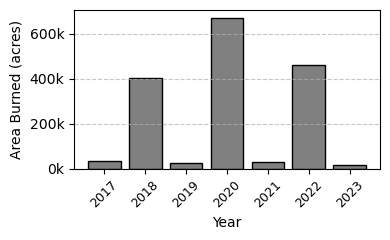

In [65]:
# plot the annual area burned
fires['Final_Acres'] = fires['Final_Acres'].astype(float)
burned_area = fires.groupby('START_YEAR')['Final_Acres'].sum().reset_index()

# set up the axis formatter
def format_thousands(x, pos):
    """Format y-axis labels to display values in 'k' for thousands."""
    return f'{int(x / 1000)}k'

formatter = FuncFormatter(format_thousands)

# Plot the results
plt.figure(figsize=(4, 2.5))
plt.bar(burned_area['START_YEAR'], burned_area['Final_Acres'], color='grey', edgecolor='black')
# plt.title('Annual Area Burned (2017-2023)', fontsize=11)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Area Burned (acres)', fontsize=10)
plt.xticks(burned_area['START_YEAR'], rotation=45, size=9)

# Apply custom formatting to y-axis
plt.gca().yaxis.set_major_formatter(formatter)
# plt.ylim(10000, None)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/Figure1b_FireCensus_annualBurnedArea.png'), dpi=300, bbox_inches='tight')

plt.show()

In [55]:
fires.columns

Index(['Fire_ID', 'Fire_Name', 'Final_Acres', 'Source', 'Aspen_Pct',
       'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'ICS_ACRES', 'CAUSE',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry',
       'FINAL_KM2', 'FINAL_HA', 'LOG_FINAL_HA'],
      dtype='object')

In [61]:
fires['Final_Acres'].astype(float).sum()

1644804.976392082

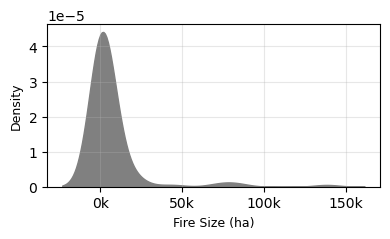

In [51]:
# plot the density distribution of fire size
plt.figure(figsize=(4, 2.5))
sns.kdeplot(fires['FINAL_HA'], fill=True, color='grey', alpha=1)
# plt.title('Distribution of Fire Sizes', fontsize=11)
plt.xlabel('Fire Size (ha)', fontsize=9)
plt.ylabel('Density', fontsize=9)

plt.gca().xaxis.set_major_formatter(formatter)

plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/Figure1c_FireCensus_fireSize.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Figure: example data ...
# load the model data
fp = os.path.join(projdir,'data/tabular/mod/model_data_cleaned.csv')
ml_da = pd.read_csv(fp)
# filter to one row per (majority of basal area)
ml_da = ml_da.loc[
    ml_da.groupby("grid_idx")["ba_live"].idxmax()
].reset_index(drop=True)
ml_da.drop(columns=['geometry'], inplace=True)
print(ml_da.columns)
ml_da.head()

In [ ]:
# drop the geometry column
# join back to the spatial data
gdf = grid[['grid_index','Fire_Name','geometry']]
gdf = gdf[gdf['Fire_Name'] == 'WILLIAMS FORK']
gdf = gdf.merge(ml_da, on="grid_index", how="inner")
print(gdf.columns[gdf.columns.str.contains("geom", case=False)])
gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs=grid.crs)

# Variables to plot — choose a few that span structure, composition, topo, fire wx
vars_to_plot = [
    "species_gp_n", "ba_live_pr", "tpp_live_pr", "aspen_ba_pr", "vpd", "erc_dv", "vs", 
    "elev", "slope", "tpi", "northness", "lf_canopy", "dist_to_perim", "overlap"
]

# Setup panel grid
fig, axs = plt.subplots(2, 7, figsize=(15, 10))

# Flatten axes for easier loop
axs = axs.flatten()

# Plot each variable
for i, var in enumerate(vars_to_plot):
    gdf.plot(
        column=var,
        cmap="viridis",
        ax=axs[i],
        markersize=5,
        legend=False  # Turn off legend
    )
    axs[i].axis("off")  # Remove axes, ticks, and labels

plt.tight_layout()
plt.subplots_adjust(top=0.6)

plt.savefig(os.path.join(projdir,'figures/example_data.png'), 
            dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Figure 2. Conceptual workflow for VIIRS AFD.
# Fire 2A. FRP detections by censor
# load the AFD points
afd = os.path.join(projdir,f'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires.gpkg')
afd = gpd.read_file(afd)

# Figure 2B. Pixel ground area
pix = os.path.join(projdir,f'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_nd.gpkg')
pix = gpd.read_file(pix)

pix.columns

In [ ]:
# subset data to example fire:
afd_fire = afd[afd['Fire_Name'] == 'WILLIAMS FORK']
pix_fire = pix[pix['Fire_Name'] == 'WILLIAMS FORK']
fire = grid[grid['Fire_Name'] == 'WILLIAMS FORK']

afd_fire = afd_fire.to_crs(4326)
pix_fire = pix_fire.to_crs(4326)
fire = fire.to_crs(4326)

# plot them
fig, axes = plt.subplots(1, 3, figsize=(8, 5), constrained_layout=True)

# Panel 1: Active fire detection points
afd_fire.plot(
    markersize=5,
    column='satellite', 
    legend=True,
    alpha=0.6,
    ax=axes[0]
)
# axes[0].set_title('Active Fire Detections', fontsize=11)
axes[0].axis('off')

# Panel 2: Pixel ground areas
pix_fire.plot(
    column='satellite', 
    legend=False, 
    alpha=0.6,
    ax=axes[1]
)
# axes[1].set_title('Pixel Ground Areas', fontsize=11)
axes[1].axis('off')  # Remove borders and axes for a clean look

# Panel 3: Aggregated FRP
n_bins = 21
quantiles = Quantiles(fire['frp_csum'], k=n_bins)
fire['frp_csum_bins'] = quantiles.yb

fire.plot(
    column='frp_csum_bins',
    cmap='inferno',
    linewidth=0,
    alpha=1.0,
    ax=axes[2]
)
# axes[2].set_title('Aggregated FRP', fontsize=11)
axes[2].axis('off')  # Remove borders and axes for a clean look

# Add a continuous colorbar to the third panel
norm = Normalize(vmin=fire['frp_csum'].min(), vmax=fire['frp_csum'].max())
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm._A = []  # Dummy array for ScalarMappable
cbar = fig.colorbar(sm, ax=axes[2], orientation='vertical', fraction=0.04, pad=0.05)
cbar.set_label("Cumulative FRP", fontsize=9)

axes[0].text(0.05, 0.95, '(A)', transform=axes[0].transAxes, 
             fontsize=10, fontweight='bold', va='top', ha='right')
axes[1].text(0.05, 0.95, '(B)', transform=axes[1].transAxes, 
             fontsize=10, fontweight='bold', va='top', ha='right')
axes[2].text(0.05, 0.95, '(C)', transform=axes[2].transAxes, 
             fontsize=10, fontweight='bold', va='top', ha='right')

for ax in axes:
    legend = ax.get_legend()
    if legend:
        legend.set_title(legend.get_title().get_text(), prop={'size': 8})  # 🔹 Reduce legend title size
        for text in legend.get_texts():
            text.set_fontsize(7)  # 🔹 Reduce legend text size
            
# Save the combined plot
plt.savefig(os.path.join(projdir, 'figures/Figure2_FRP_GriddingScheme.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Figure S2. Distribution of pixel ground area based on swath position.

In [ ]:
# Bin the sample positions into intervals
bin_edges = np.linspace(pix_area['sample'].min(), pix_area['sample'].max(), 20)  # Create 20 bins
pix_area['sample_bin'] = pd.cut(pix_area['sample'], bins=bin_edges, labels=bin_edges[:-1])

# Calculate mean pixel area for each bin
sample_summary = pix_area.groupby('sample_bin')['pix_area'].mean().reset_index()
sample_summary['sample_bin'] = sample_summary['sample_bin'].astype(float)  # Convert bin labels to float

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5), constrained_layout=False)
fig.subplots_adjust(hspace=0.1, wspace=0.4)  

# ======= Left Plot: Histogram =======
sns.histplot(
    data=pix_area, 
    x="pix_area", 
    bins=50,  # Fine-grained bins for clarity
    color="#1f77b4", 
    kde=False, 
    ax=axes[0]
)

axes[0].set_xlabel("Pixel Area ($km^2$)", fontsize=9)
axes[0].set_ylabel("Frequency", fontsize=9)

# ======= Right Plot: Line Plot =======
axes[1].plot(
    sample_summary['sample_bin'], 
    sample_summary['pix_area'], 
    marker='o', color='orange', label="Mean Pixel Area"
)
axes[1].set_xlabel("Sample Position", fontsize=9)
axes[1].set_ylabel("Mean Pixel Area ($km^2$)", fontsize=9)
axes[0].tick_params(axis='both', which='major', labelsize=8)  # Change 10 to desired font size
axes[1].tick_params(axis='both', which='major', labelsize=8)

axes[1].grid(True, linestyle='--', alpha=0.6)

axes[0].text(-0.1, 1.1, "(A)", transform=axes[0].transAxes, fontsize=10, fontweight="bold", va="top", ha="right")
axes[1].text(-0.1, 1.1, "(B)", transform=axes[1].transAxes, fontsize=10, fontweight="bold", va="top", ha="right")

# Save the plot
out_plot = os.path.join(projdir, 'figures/FigureS1_PixelGroundArea_Distribution.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

# Show the plots
plt.show()